# Pre procesamiento

Como habíamos dicho es mejor pre procesar las palabras

In [1]:
from string import punctuation
import pandas as pd
import re
import unicodedata
from math import log2

Veamos el formato de los mensajes sin procesar

In [2]:
df = pd.read_csv('corpus.csv')
df.head(30)

,id,owner,date,hour,message
0,0,USER0,10/16/17,17:44,https://m.facebook.com/story.php?story_fbid=14...
1,0,USER1,10/16/17,17:54,Hola Te confundiste de numero
2,1,USER0,6/10/17,16:58,😂😂😂😂😂😂😂😂😂😂
3,1,USER1,6/10/17,17:43,Que es este lugar 👀
4,1,USER2,6/10/17,17:44,Qur hace este aqui
5,1,USER2,6/10/17,17:44,🤣
6,1,USER3,6/10/17,17:44,Bienvenido
7,1,USER1,6/10/17,17:50,Vengo a pasarle fotos obscenas e irme ?)
8,1,USER1,6/10/17,17:50,Pasarles
9,1,USER3,6/10/17,17:51,👀


Debido a la mala distribución de las palabras, definiremos algunas reglas de __pre-procesamiento__ que creemos que servirán en nuestra tarea. En los comentarios de cada función daremos una explicación un poco más detallada acerca de la normalización.

In [3]:
def rm_num(text):
    """
    cambiar digitos de numeros por la palabra NUM

    :text -- texto
    """
    return re.sub('(\d+[\WxX]*[^ ]*)+', 'NUM', text)

def rm_tildes(text):
    """
    remueve tildes

    :text -- texto
    """
    return ''.join((c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'))

def rm_media(text):
    """
    remueve media

    :text -- texto
    """
    return re.sub(r'<archivo omitido>|<media omitted>', 'MEDIA', text)

def rm_repeated(text):
    """
    remueve letras que se repiten en una palabra
    Ejemplo: holaaa -> hola

    :text -- texto
    """
    return re.sub(r'([aeourshmi])\1{2,}', r'\1', text)

def rm_ok(text):
    """
    normaliza la palabra ok
    Ejemplo: oka -> ok

    :text -- texto
    """
    return re.sub('(ok)+[akis]*', 'ok', text)

def rm_ja(text):
    """
    normaliza la palabra jaja
    Ejemplo: jajajajajajaja -> ja

    :text -- texto
    """
    return re.sub('(ja[ja(js)]*)+', 'ja', text)

def rm_si(text):
    """
    normaliza la palabra si
    Ejemplo: siiiiii -> si

    :text -- texto
    """
    return re.sub('[s]+[i]+', 'si', text)

def clean_text(text):
    """
    llama a todas las funciones para normalizar texto
    Ejemplo: siiiiii -> si

    :text -- texto
    """
    return rm_num(rm_si(rm_ok(rm_ja(rm_repeated(rm_media(rm_tildes(text.lower())))))))

## ¿Cómo tratar los signos de puntuación y los emojis?

Uno de los problemas a tratar es: ¿Qué hacer con los signos de puntuación? ¿Y con los emojis? ¿Se remueven o se tratan como palabra? ¿Algunas se remueven y otras se las tiene en cuenta como contexto? **¿Cómo tratar los emojis repetidos?**

Se deberá también tener en cuenta que muchas palabras aparecen concatenadas con los signos de puntuación y los emojis, ya sea por error de tipeo, o por el uso del signo. Ej. "hola.que haces??😄"

Definimos las reglas

In [4]:
from emoji import UNICODE_EMOJI

PUNCTUATION = punctuation + '¡' + '¿'
NOT_SIGNIFICANT = re.sub('[?!\"$]+', '', PUNCTUATION)
EMOJI = u''.join(c for c in UNICODE_EMOJI)

def rm_punct(text):
    """
    Remueve signos de puntuación. Reemplaza por un espacio.
    hola.que haces??😄 -> hola que haces  😄
    """
    return re.sub('{1}{0}{1}'.format(PUNCTUATION, '[]'), ' ', text)

def rm_extra_punct(text):
    """
    Remueve signos de puntuación repetidos y agrega espacio entre ellos.
    ???!!..' -> ? ! . '
    """
    return re.sub(r'({1}{0}{2})\1*'.format(PUNCTUATION, '[', ']'), r' \1 ', text)

def rm_not_signif(text):
    """
    Remueve signos de puntuación no significativos
    ???!!!..' -> ???!!!
    """
    return re.sub('{1}{0}{1}'.format(NOT_SIGNIFICANT, '[]'), ' ', text)

def rm_extra_emojis(text):
    """
    Remueve emojis repetidos y agrega espacio entre ellos.
    hola.que haces??😄😄😄 -> hola.que haces?? 😄
    """
    return re.sub(r'({1}{0}{2})\1*'.format(EMOJI, '[', ']'), r' \1 ', text)

def rm_emojis(text):
    """
    Remueve emojis
    hola.que haces??😄 -> hola.que haces??
    """
    return ''.join(c for c in text if c not in UNICODE_EMOJI)

def rm_extra_space(text):
    """
    Remueve espacios extra
    hola   que haces? ? -> hola que haces? ?
    """
    return ' '.join(text.split())

### Tratando los signos de puntuación y los emojis como palabra
En esta etapa se tratarán todos los signos y los emojis como palabras. El preprocesamiento consiste en añadir los espacios correspondientes y eliminar repeticiones de caracteres. Ej. "hola.que haces??😄" -> "hola . que haces ? 😄"

In [5]:
def pre1(text):
    return rm_extra_space(rm_extra_emojis(rm_extra_punct(clean_text(text))))

### Removiendo signos de puntuación menos significativos
Similar a la etapa anterior, pero removiendo sólo los signos que creemos no aportan al contexto. Ej. "hola.que haces??😄" -> "hola que haces ? 😄"

In [6]:
def pre2(text):
    return rm_extra_space(rm_extra_emojis(rm_extra_punct(rm_not_signif(clean_text(text)))))

### Quitando todos los signos de puntuación
En esta etapa removemos todos los signos de puntuación y preprocesamos los emojis. Ej. "hola.que haces??😄" -> "hola que haces 😄"

In [7]:
def pre3(text):
    return rm_extra_space(rm_extra_emojis(rm_punct(clean_text(text))))

### Quitando todos los signos de puntuación y los emojis
Para mejorar aún más la distribución, probamos quitando también los emojis.

In [8]:
def pre4(text):
    return rm_extra_space(rm_punct(rm_emojis(clean_text(text))))

Guardamos los mensajes preprocesados

In [9]:
df_cleaned_pre1 = pd.DataFrame(
    [
        (id, owner, date, hour, pre1(message))
        for (id, owner, date, hour, message) in [
            row for index, row in df.iterrows()
        ]
    ],
    columns=['id', 'owner', 'date', 'hour', 'message']
)

In [10]:
df_cleaned_pre2 = pd.DataFrame(
    [
        (id, owner, date, hour, pre2(message))
        for (id, owner, date, hour, message) in [
            row for index, row in df.iterrows()
        ]
    ],
    columns=['id', 'owner', 'date', 'hour', 'message']
)

In [11]:
df_cleaned_pre3 = pd.DataFrame(
    [
        (id, owner, date, hour, pre3(message))
        for (id, owner, date, hour, message) in [
            row for index, row in df.iterrows()
        ]
    ],
    columns=['id', 'owner', 'date', 'hour', 'message']
)

In [12]:
df_cleaned_pre4 = pd.DataFrame(
    [
        (id, owner, date, hour, pre4(message))
        for (id, owner, date, hour, message) in [
            row for index, row in df.iterrows()
        ]
    ],
    columns=['id', 'owner', 'date', 'hour', 'message']
)

In [13]:
df_cleaned_pre1.head(10)

,id,owner,date,hour,message
0,0,USER0,10/16/17,17:44,https : / m . facebook . com / story . php ? s...
1,0,USER1,10/16/17,17:54,hola te confundiste de numero
2,1,USER0,6/10/17,16:58,😂
3,1,USER1,6/10/17,17:43,que es este lugar 👀
4,1,USER2,6/10/17,17:44,qur hace este aqui
5,1,USER2,6/10/17,17:44,🤣
6,1,USER3,6/10/17,17:44,bienvenido
7,1,USER1,6/10/17,17:50,vengo a pasarle fotos obscenas e irme ? )
8,1,USER1,6/10/17,17:50,pasarles
9,1,USER3,6/10/17,17:51,👀


In [14]:
df_cleaned_pre2.head(10)

,id,owner,date,hour,message
0,0,USER0,10/16/17,17:44,https m facebook com story php ? story fbid NUM
1,0,USER1,10/16/17,17:54,hola te confundiste de numero
2,1,USER0,6/10/17,16:58,😂
3,1,USER1,6/10/17,17:43,que es este lugar 👀
4,1,USER2,6/10/17,17:44,qur hace este aqui
5,1,USER2,6/10/17,17:44,🤣
6,1,USER3,6/10/17,17:44,bienvenido
7,1,USER1,6/10/17,17:50,vengo a pasarle fotos obscenas e irme ?
8,1,USER1,6/10/17,17:50,pasarles
9,1,USER3,6/10/17,17:51,👀


In [15]:
df_cleaned_pre3.head(10)

,id,owner,date,hour,message
0,0,USER0,10/16/17,17:44,https m facebook com story php story fbid NUM
1,0,USER1,10/16/17,17:54,hola te confundiste de numero
2,1,USER0,6/10/17,16:58,😂
3,1,USER1,6/10/17,17:43,que es este lugar 👀
4,1,USER2,6/10/17,17:44,qur hace este aqui
5,1,USER2,6/10/17,17:44,🤣
6,1,USER3,6/10/17,17:44,bienvenido
7,1,USER1,6/10/17,17:50,vengo a pasarle fotos obscenas e irme
8,1,USER1,6/10/17,17:50,pasarles
9,1,USER3,6/10/17,17:51,👀


In [16]:
df_cleaned_pre4.head(10)

,id,owner,date,hour,message
0,0,USER0,10/16/17,17:44,https m facebook com story php story fbid NUM
1,0,USER1,10/16/17,17:54,hola te confundiste de numero
2,1,USER0,6/10/17,16:58,
3,1,USER1,6/10/17,17:43,que es este lugar
4,1,USER2,6/10/17,17:44,qur hace este aqui
5,1,USER2,6/10/17,17:44,
6,1,USER3,6/10/17,17:44,bienvenido
7,1,USER1,6/10/17,17:50,vengo a pasarle fotos obscenas e irme
8,1,USER1,6/10/17,17:50,pasarles
9,1,USER3,6/10/17,17:51,


In [17]:
df_cleaned_pre1.to_csv(path_or_buf='preprocessed_corpus_pre1.csv')
df_cleaned_pre2.to_csv(path_or_buf='preprocessed_corpus_pre2.csv')
df_cleaned_pre3.to_csv(path_or_buf='preprocessed_corpus_pre3.csv')
df_cleaned_pre4.to_csv(path_or_buf='preprocessed_corpus_pre4.csv')

## Distribución de palabras

Veamos como sería la nueva distribución

In [18]:
from collections import Counter, defaultdict
from itertools import chain

counter_pre1 = Counter(chain.from_iterable(df_cleaned_pre1.message.map(lambda x: x.split())))
counter_pre2 = Counter(chain.from_iterable(df_cleaned_pre2.message.map(lambda x: x.split())))
counter_pre3 = Counter(chain.from_iterable(df_cleaned_pre3.message.map(lambda x: x.split())))
counter_pre4 = Counter(chain.from_iterable(df_cleaned_pre4.message.map(lambda x: x.split())))

In [19]:
df_distribution_pre1 = pd.DataFrame(
    data={
        'word': list(counter_pre1.keys()),
        'counter': list(counter_pre1.values())
    }
)

In [20]:
df_distribution_pre2 = pd.DataFrame(
    data={
        'word': list(counter_pre2.keys()),
        'counter': list(counter_pre2.values())
    }
)

In [21]:
df_distribution_pre3 = pd.DataFrame(
    data={
        'word': list(counter_pre3.keys()),
        'counter': list(counter_pre3.values())
    }
)

In [22]:
df_distribution_pre4 = pd.DataFrame(
    data={
        'word': list(counter_pre4.keys()),
        'counter': list(counter_pre4.values())
    }
)

In [23]:
df_distribution_pre1.to_csv(path_or_buf='distribution_pre1.csv')
df_distribution_pre2.to_csv(path_or_buf='distribution_pre2.csv')
df_distribution_pre3.to_csv(path_or_buf='distribution_pre3.csv')
df_distribution_pre4.to_csv(path_or_buf='distribution_pre4.csv')

In [24]:
df_distribution_pre1.describe()

,counter
count,46810.000000
mean,22.843239
std,412.899798
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,29668.000000


In [25]:
sum(df_distribution_pre1.counter == 1) / df_distribution_pre1.counter.count()

0.52132023071993161

In [26]:
df_distribution_pre2.describe()

,counter
count,46781.000000
mean,21.610633
std,390.335418
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,29668.000000


In [27]:
sum(df_distribution_pre2.counter == 1) / df_distribution_pre1.counter.count()

0.52132023071993161

In [28]:
df_distribution_pre3.describe()

,counter
count,46777.000000
mean,20.970905
std,378.487835
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,29668.000000


In [29]:
sum(df_distribution_pre3.counter == 1) / df_distribution_pre3.counter.count()

0.5216880090642837

In [30]:
df_distribution_pre4.head(10)

,counter,word
0,1,lujoso
1,1,dejenla
2,2,concentrarme
3,3,disenador
4,1,implicitas
5,1,limpiezas
6,1,cosasc
7,2,sogas
8,1,posesivos
9,1,reconociendo


In [31]:
df_distribution_pre4.describe()

,counter
count,46446.000000
mean,20.489752
std,379.083536
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,29668.000000


In [32]:
sum(df_distribution_pre4.counter == 1) / df_distribution_pre4.counter.count()

0.52882917797011586

Logramos reducir a un 53% la cantidad de palabras únicas, pero sin embargo sigue siendo bastante alta.

In [33]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.boxplot(x=df_distribution_pre4["counter"])

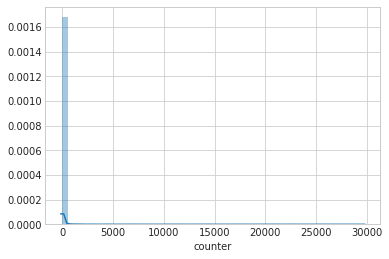

In [34]:
sns.distplot(df_distribution_pre4["counter"])

Al igual que pasaba anteriormente, los gráficos siguen sin brindar mucha información debido a la mala distribución de las palabras. Por ende, hemos decidido quedarnos con las palabras que ocurran más de 20 veces (la media).

In [35]:
new_df = df_distribution_pre4[df_distribution_pre4.counter >= 20]

__Es decir, sólo nos quedaríamos con el__

In [36]:
new_df.counter.count() / df_distribution_pre4.counter.count()

0.073784610084829699

7% de las palabras totales en la distribución

In [37]:
df_new = new_df.sort_values('counter', ascending=False).head(200).append(new_df.sort_values('counter').head(200))
df_new

,counter,word
4218,29668,que
5107,25773,de
44271,22586,a
21012,22483,no
20218,21024,la
35799,19977,ja
2969,19880,el
6997,18476,y
5479,17302,NUM
32792,16066,MEDIA


Las listas de palabras tienen más sentido

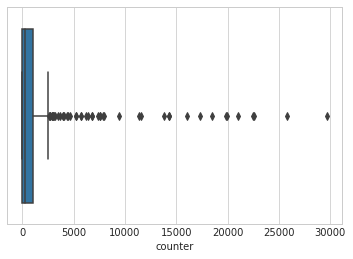

In [38]:
ax = sns.boxplot(x=df_new['counter'])

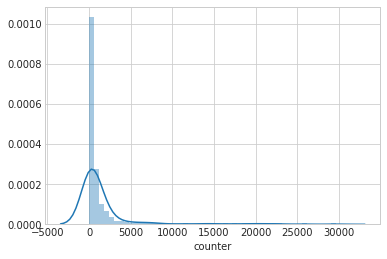

In [39]:
sns.distplot(df_new["counter"])

In [61]:
df_new.counter = df_new.counter.map(log2)

Como vimos que la distribución mejora un poco, podemos filtrar las palabras que no tengas al menos 20 aparciones.

Por lo menos ahora se puede ver una pequeña mejora en la distribución

#### Graficando logaritmicamente en base 2

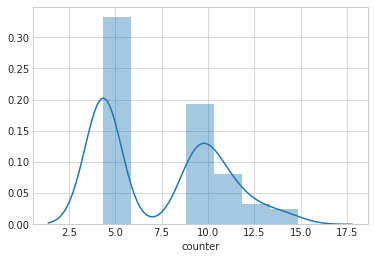

In [63]:
sns.distplot(df_new.counter)

Es más leíble la distribucción, sin embargo los resultados no son muy prometedores. Hay un gran hueco en la distribución entre el 5 y el 9.

In [40]:
dict_pre1 = dict(df_distribution_pre1[['word', 'counter']].to_dict('split')['data'])
dict_pre2 = dict(df_distribution_pre2[['word', 'counter']].to_dict('split')['data'])
dict_pre3 = dict(df_distribution_pre3[['word', 'counter']].to_dict('split')['data'])
dict_pre4 = dict(df_distribution_pre4[['word', 'counter']].to_dict('split')['data'])

In [41]:
df_cleaned_pre1.message = df_cleaned_pre1.message.map(lambda phrase: " ".join(filter(lambda word: dict_pre1[word] >= 20, phrase.split())))
df_cleaned_pre2.message = df_cleaned_pre2.message.map(lambda phrase: " ".join(filter(lambda word: dict_pre2[word] >= 20, phrase.split())))
df_cleaned_pre3.message = df_cleaned_pre3.message.map(lambda phrase: " ".join(filter(lambda word: dict_pre3[word] >= 20, phrase.split())))
df_cleaned_pre4.message = df_cleaned_pre4.message.map(lambda phrase: " ".join(filter(lambda word: dict_pre4[word] >= 20, phrase.split())))

In [42]:
df_cleaned_pre1.to_csv(path_or_buf='preprocessed_corpus_pre1_20words.csv')
df_cleaned_pre2.to_csv(path_or_buf='preprocessed_corpus_pre2_20words.csv')
df_cleaned_pre3.to_csv(path_or_buf='preprocessed_corpus_pre3_20words.csv')
df_cleaned_pre4.to_csv(path_or_buf='preprocessed_corpus_pre4_20words.csv')